In [1]:
import copy
import random
import os
import time

from IPython.display import clear_output, display, HTML
from tqdm import tqdm

from google.colab import drive, files
from collections import Counter
from PIL import Image

import math
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

sns.set(style="darkgrid")

import tensorflow as tf

# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
# tf.debugging.set_log_device_placement(True)
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
# for gpu in tf.config.experimental.list_physical_devices('GPU'):
#     # tf.config.experimental.set_memory_growth(gpu, True)
#     # tf.config.set_visible_devices(gpu, 'GPU')
#     tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
# # os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(
# #     str(i) for i in range(len(tf.config.experimental.list_logical_devices('GPU'))))
# # os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# strategy = tf.distribute.MirroredStrategy(tf.config.list_logical_devices('GPU'),
#                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

keras = tf.keras
from keras.utils import array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [2]:
drive.mount('/content/gdrive')

# copy kaggle key to proper folder
if not os.path.isfile('/root/.kaggle/kaggle.json'):
  if not os.path.isfile('/content/gdrive/MyDrive/kaggle/kaggle.json'):
    files.upload() #this will prompt you to update the json

    !pip install -q kaggle
    !mkdir -p /content/gdrive/MyDrive/kaggle
    !mv kaggle.json /content/gdrive/MyDrive/kaggle/

  !mkdir -p ~/.kaggle
  !cp /content/gdrive/MyDrive/kaggle/kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

DATA_PATH = "/content/gdrive/MyDrive/isic-2019"
if not os.path.exists(f"{DATA_PATH}"):
  # TODO fix this bash script
  # set environment variable to be used by bash commands
  os.environ["DATA_PATH"] = DATA_PATH
  # download and unzip data
  !kaggle datasets download --unzip -o -d andrewmvd/isic-2019 -p $DATA_PATH
  # rename outer folder name
  !mv $DATA_PATH/ISIC_2019_Training_Input $DATA_PATH/ISIC_2019_Training_Input_1
  # move inner image directory to outer directory
  !mv $DATA_PATH/ISIC_2019_Training_Input_1/ISIC_2019_Training_Input $DATA_PATH/ISIC_2019_Training_Input
  # remove the empty directory
  !rmdir $DATA_PATH/ISIC_2019_Training_Input_1

Mounted at /content/gdrive
kaggle.json


In [8]:
# Constants
STATE_PATH = f"{DATA_PATH}/state"
MODELS_PATH = f"{DATA_PATH}/models"

IMAGE_PATH = f'{DATA_PATH}/ISIC_2019_Training_Input'
IMAGE_TYPE = 'jpg'

TARGET_SIZE = (224, 224)
CHANNELS = 3
CONTRAST_FACTOR = 3  # 2 is performing better and so choosing that instead
# CONTRAST_FACTOR = 2
DELTA = 0.3
IS_FLIP_ON = True
RANDOM_STATE = 42
# KERNEL_SIZE = (5, 5)  # decreasing seeing 3,3 doing better
KERNEL_SIZE = (3, 3)
# LEARNING_RATE = 0.001  # decreasing seeing too much ripple effect
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
# GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
# print(f"Global Batch Size: {GLOBAL_BATCH_SIZE}")
TEST_SIZE = 0.2
# EPOCHS = 5  # validation accuracy seems to increase with the new learning rate and so increasing the number of epochs
EPOCHS = 25

In [9]:
def reset_random_seeds(seed=RANDOM_STATE):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def clear_session():
    tf.keras.backend.clear_session()

In [10]:
df_metadata = pd.read_csv(f'{DATA_PATH}/ISIC_2019_Training_Metadata.csv')
df_truth = pd.read_csv(f'{DATA_PATH}/ISIC_2019_Training_GroundTruth.csv')

In [11]:
labels = df_truth.columns
labels = labels[1:]
print(labels)
label_mapping = {i: label for i, label in enumerate(labels)}
print(label_mapping)

Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')
{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC', 8: 'UNK'}


In [12]:
dense_labels = df_truth[labels]
dense_labels = dense_labels.values
print('Dense Labels...')
display(dense_labels)
truth_labels = np.argmax(dense_labels, axis=-1)
print('Truth Labels...')
display(truth_labels)

Dense Labels...


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Truth Labels...


array([1, 1, 0, ..., 0, 1, 4])

In [13]:
df_truth['label'] = truth_labels.tolist()
display(df_truth)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [14]:
df_joined = df_metadata.join(df_truth.set_index('image'), on='image', how='left')
display(df_joined)

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [15]:
# Site details add more information to model and so fill with unknown if not available
print(
    f"Count of null values in anatom_site_general column before null fill: {sum(df_joined['anatom_site_general'].isnull())}")
df_joined['anatom_site_general'] = df_joined['anatom_site_general'].fillna('unknown')
print(
    f"Count of null values in anatom_site_general column after null fill: {sum(df_joined['anatom_site_general'].isnull())}")

Count of null values in anatom_site_general column before null fill: 2631
Count of null values in anatom_site_general column after null fill: 0


In [16]:
# Sex details add more information to model and so fill with unknown if not available
print(f"Count of null values in sex column before null fill: {sum(df_joined['sex'].isnull())}")
df_joined['sex'] = df_joined['sex'].fillna('unknown')
print(f"Count of null values in sex column after null fill: {sum(df_joined['sex'].isnull())}")

Count of null values in sex column before null fill: 384
Count of null values in sex column after null fill: 0


In [17]:
# Age is important for the model and so we remove rows with na/inf/zero values
df_cleaned = df_joined[~df_joined['age_approx'].isnull()]
print(f"Observations in cleaned dataframe before na/inf/zero remove: {len(df_cleaned)}")
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned.dropna(how="all", inplace=True)
df_cleaned = df_cleaned[df_cleaned['age_approx'] > 0]
print(f"Observations in cleaned dataframe after na/inf/zero remove: {len(df_cleaned)}")

Observations in cleaned dataframe before na/inf/zero remove: 24894
Observations in cleaned dataframe after na/inf/zero remove: 24840


In [18]:
# Convert age column to uint8 for resampling
# df_cleaned['age_approx'] = df_cleaned['age_approx'].astype(np.uint8)
# display(df_cleaned)

In [19]:
# decreasing the scope of anatomy site can provide more information and so getting a more generic information
df_cleaned['anatomy_site'] = df_cleaned['anatom_site_general'].apply(lambda anatomy: anatomy.split()[-1])
display(df_cleaned)

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label,anatomy_site
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,torso
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,torso
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,extremity
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,extremity
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,torso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,head/neck
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,torso
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,extremity
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,palms/soles


In [20]:
with open(f"{STATE_PATH}/images_seen.txt") as seen_file:
    images_seen = seen_file.read()
    images_seen = images_seen.split('\n')
    images_seen = set(images_seen)
df_cleaned['is_seen'] = df_cleaned['image'].apply(lambda name: name in images_seen)

df_seen = df_cleaned[df_cleaned['is_seen']].copy()
display(df_seen)
df_test = df_cleaned[df_cleaned['is_seen'] == False].copy()
# Limit the number of test results to speed up experiments
# df_test = df_test.head(df_seen.shape[0])
display(df_test)

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label,anatomy_site,is_seen
2915,ISIC_0024318,65.0,lower extremity,HAM_0002450,female,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,extremity,True
2967,ISIC_0024370,55.0,unknown,HAM_0001780,male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,unknown,True
2983,ISIC_0024386,40.0,lower extremity,HAM_0005112,female,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,extremity,True
3072,ISIC_0024475,35.0,head/neck,HAM_0003873,male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,head/neck,True
3114,ISIC_0024517,65.0,posterior torso,HAM_0001894,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,torso,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25256,ISIC_0073141,45.0,anterior torso,BCN_0005520,female,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,torso,True
25259,ISIC_0073144,75.0,anterior torso,BCN_0004091,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,torso,True
25287,ISIC_0073193,35.0,anterior torso,BCN_0002147,male,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,torso,True
25289,ISIC_0073195,70.0,lower extremity,BCN_0005492,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,extremity,True


,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label,anatomy_site,is_seen
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,torso,False
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,torso,False
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,extremity,False
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,extremity,False
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,torso,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,head/neck,False
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,torso,False
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,extremity,False
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,palms/soles,False


## Baseline

Predicting everything as MEL (label = 0) since that is the most dangerous type of skin lesion!!!

In [21]:
accuracy_test = (df_test['label'] == 0).sum() / df_test.shape[0]
print(f"Accuracy on test data: {accuracy_test * 100:.2f}%")

Accuracy on test data: 18.21%


In [22]:
def load_img_data_in_batch(img_names):
  images = []

  for img_name in np.array(img_names):
    img = load_img(f"{IMAGE_PATH}/{bytes.decode(img_name)}.{IMAGE_TYPE}", target_size=TARGET_SIZE)
    img = img_to_array(img)
    images.append(img)
  return np.stack(images)


def load_img_data(img_names):
  images = []

  img_names_dataset = tf.data.Dataset.from_tensor_slices((img_names)).batch(BATCH_SIZE)
  for dataset in tqdm(img_names_dataset):
    imgs = load_img_data_in_batch(dataset)
    images.append(imgs)
  
  return np.concatenate(images)

In [23]:
def aug_img_data(images, size=TARGET_SIZE, delta=DELTA, contrast_factor=CONTRAST_FACTOR, is_flip_on=IS_FLIP_ON,
                 **kwargs):
    # make a copy of images
    images_aug = copy.deepcopy(images)
    # image resize
    images_aug = tf.image.resize(images_aug, size=size)

    # brightness
    images_aug = tf.image.adjust_brightness(images_aug, delta=delta)
    # contrast
    images_aug = tf.image.adjust_contrast(images_aug, contrast_factor=contrast_factor)
    # random flip
    if is_flip_on:
        images_aug = tf.image.random_flip_left_right(images_aug)

    return images_aug

In [24]:
# LIMIT = GLOBAL_BATCH_SIZE * strategy.num_replicas_in_sync
# df_seen = df_seen.iloc[:LIMIT]
# df_test = df_test.iloc[:LIMIT * strategy.num_replicas_in_sync]

img_seen = load_img_data(df_seen['image'])
y_seen = df_seen['label']

img_train, img_val, y_train, y_val = train_test_split(img_seen, y_seen, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Length of training data: {img_train.shape[0]}")
print(f"Length of validation data: {img_val.shape[0]}")

img_test = load_img_data(df_test['image'])
y_test = df_test['label']
print(f"Length of test data: {img_test.shape[0]}")

image_index = {name: i for i, name in enumerate(df_cleaned['image'])}
rev_image_index = {i: name for i, name in enumerate(df_cleaned['image'])}
df_seen['image'] = df_seen['image'].apply(lambda name: image_index[name])
df_test['image'] = df_test['image'].apply(lambda name: image_index[name])

100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Length of training data: 1216
Length of validation data: 304


100%|██████████| 729/729 [06:01<00:00,  2.02it/s]


Length of test data: 23320


In [25]:
def plot_history(hist):
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

## CNN

In [26]:
def build_cnn_model(kernel_size=KERNEL_SIZE, strides=(1, 1), pool_size=(2, 2), optimizer='Adam',
                    learning_rate=LEARNING_RATE, conv_filters=[32, 64], hidden_units=[1024, 256], dropout_rate=0.8,
                    **kwargs):
    # def build_cnn_model(kernel_size=(5, 5), strides=(1, 1), pool_size=(2, 2), optimizer='Adam', learning_rate=0.001, conv_filters=[32, 64], hidden_units=[1024], dropout_rate=0.5, **kwargs):
    clear_session()
    reset_random_seeds()

    model = keras.Sequential()

    for i, filters in enumerate(conv_filters):
        i += 1
        model.add(keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                                      name=f'conv_{i}', activation='relu'))
        model.add(keras.layers.MaxPool2D(pool_size=pool_size, name=f'pool_{i}'))

    model.add(keras.layers.Flatten())

    for i, units in enumerate(hidden_units):
        i += 1
        model.add(keras.layers.Dropout(rate=dropout_rate))
        model.add(keras.layers.Dense(units=units, name=f'fc_{i}', activation='relu'))

    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=len(labels), name='output', activation="softmax"))
    model.build(input_shape=(None, *TARGET_SIZE, 3))

    optimizer_mapping = {
        'sgd': keras.optimizers.SGD,
        'adam': keras.optimizers.Adam,
    }
    optimizer = optimizer_mapping[optimizer.lower()]
    optimizer = optimizer(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

# augment train data
img_seen_aug = aug_img_data(img_seen)
img_seen_aug = tf.concat([img_seen, img_seen_aug], axis=0)
y_seen_aug = tf.concat([y_seen, y_seen], axis=0)

# shuffle the data
reset_random_seeds()
shuffle = tf.random.shuffle(tf.range(tf.shape(img_seen_aug)[0], dtype=tf.int32))
img_seen_aug = tf.gather(img_seen_aug, shuffle)
y_seen_aug = tf.gather(y_seen_aug, shuffle).numpy()
print(f"Length of augmented seen data: {img_seen_aug.shape[0]}")

if 'model_cnn' in locals() or 'model_cnn' in globals():
    del model_cnn
model_cnn = build_cnn_model()
model_cnn.summary()

history_cnn = model_cnn.fit(img_seen_aug, y_seen_aug, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TEST_SIZE).history
plot_history(history_cnn)

i = 1100
print(f"embeddings: {build_embedding_df(model_cnn, img_seen_aug[i:i + 1]).to_numpy()}")
print(f"predicts: {model_cnn.predict(img_seen_aug[i:i+1])}")
print(f"ground-truth: {y_seen_aug[i:i+1]}")

default_args = {
    "kernel_size": KERNEL_SIZE,
    "strides": (1, 1),
    "pool_size": (2, 2),
    "optimizer": "Adam",
    "learning_rate": LEARNING_RATE,
    "delta": DELTA,
    "contrast_factor": CONTRAST_FACTOR,
    "is_flip_on": IS_FLIP_ON
}
new_args = {
    # "kernel_size": (3, 3),
    "strides": (2, 2),
    # "pool_size": (3, 3),
    # "optimizer": "SGD",  # unable to train and so not considering this
    # "learning_rate": 0.01,  # this is causing ripple effect
    "delta": 0.1,  # this is performing better and so using as default
    "contrast_factor": 2,  # this is performing better and so using as default
    "is_flip_on": False
}
# history_cnn = history_cnn.history
results = [[
    history_cnn['accuracy'][-1],
    history_cnn['val_accuracy'][-1],
    default_args['kernel_size'],
    default_args['strides'],
    default_args['pool_size'],
    default_args['learning_rate'],
    default_args['optimizer'],
    default_args['delta'],
    default_args['contrast_factor'],
    default_args['is_flip_on']
]]

for k, v in new_args.items():
    time.sleep(30)
    # clear_output(wait=True)
    exp_args = copy.deepcopy(default_args)
    exp_args[k] = v
    print(f"Experiment: {exp_args}")
    print(f"Modified: {k} = {v}")

    img_seen_aug = aug_img_data(img_seen, **exp_args)
    img_seen_aug = tf.concat([img_seen, img_seen_aug], axis=0)
    y_seen_aug = tf.concat([y_seen, y_seen], axis=0)

    # shuffle the data
    reset_random_seeds()
    shuffle = tf.random.shuffle(tf.range(tf.shape(img_seen_aug)[0], dtype=tf.int32))
    img_seen_aug = tf.gather(img_seen_aug, shuffle)
    y_seen_aug = tf.gather(y_seen_aug, shuffle).numpy()
    # print(f"Length of augmented seen data: {img_seen_aug.shape[0]}")

    if 'model_cnn' in locals() or 'model_cnn' in globals():
        del model_cnn
    model_cnn = build_cnn_model(**exp_args)
    model_cnn.summary()

    history_cnn = model_cnn.fit(img_seen_aug, y_seen_aug, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TEST_SIZE).history
    plot_history(history_cnn)

    results.append([
        history_cnn['accuracy'][-1],
        history_cnn['val_accuracy'][-1],
        exp_args['kernel_size'],
        exp_args['strides'],
        exp_args['pool_size'],
        exp_args['learning_rate'],
        exp_args['optimizer'],
        exp_args['delta'],
        exp_args['contrast_factor'],
        exp_args['is_flip_on']
    ])

    i = 1100
    print(f"embeddings: {build_embedding_df(model_cnn, img_seen_aug[i:i + 1]).to_numpy()}")
    print(f"predicts: {model_cnn.predict(img_seen_aug[i:i+1])}")
    print(f"ground-truth: {y_seen_aug[i:i+1]}")

df_cnn_results = pd.DataFrame(results)
display(HTML(df_cnn_results.to_html(index=False)))

## Create Image Embeddings

#### Selected CNN

In [27]:
CNN_MODEL_FILENAME = f"{MODELS_PATH}/model_cnn.h5"
if not os.path.isfile(CNN_MODEL_FILENAME):
    default_args = {
        "kernel_size": KERNEL_SIZE,
        "strides": (1, 1),
        "pool_size": (2, 2),
        "optimizer": "Adam",
        "learning_rate": LEARNING_RATE,
        "delta": DELTA,
        "contrast_factor": CONTRAST_FACTOR,
        "is_flip_on": IS_FLIP_ON
    }
    exp_args = {
        **default_args,
        "strides": (2, 2),
        "contrast_factor": 2
    }

    # time.sleep(30)
    # clear_output(wait=True)
    print(f"Experiment: {exp_args}")

    img_seen_aug = aug_img_data(img_seen, **exp_args)
    img_seen_aug = tf.concat([img_seen, img_seen_aug], axis=0)
    y_seen_aug = tf.concat([y_seen, y_seen], axis=0)

    # shuffle the data
    reset_random_seeds()
    shuffle = tf.random.shuffle(tf.range(tf.shape(img_seen_aug)[0], dtype=tf.int32))
    img_seen_aug = tf.gather(img_seen_aug, shuffle)
    y_seen_aug = tf.gather(y_seen_aug, shuffle).numpy()

    if 'model_cnn' in locals() or 'model_cnn' in globals():
        del model_cnn

    # with strategy.scope():
    model_cnn = build_cnn_model(**exp_args)

    model_cnn.fit(img_seen_aug, y_seen_aug, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TEST_SIZE)
    model_cnn.save(CNN_MODEL_FILENAME)

# model_cnn.summary()

Experiment: {'kernel_size': (3, 3), 'strides': (2, 2), 'pool_size': (2, 2), 'optimizer': 'Adam', 'learning_rate': 0.0005, 'delta': 0.3, 'contrast_factor': 2, 'is_flip_on': True}
Epoch 1/25
76/76 [==============================] - 10s 14ms/step - loss: 60.8938 - accuracy: 0.1238 - val_loss: 2.3098 - val_accuracy: 0.1530
Epoch 2/25
76/76 [==============================] - 1s 11ms/step - loss: 2.9850 - accuracy: 0.1094 - val_loss: 2.1658 - val_accuracy: 0.1530
Epoch 3/25
76/76 [==============================] - 1s 11ms/step - loss: 2.3999 - accuracy: 0.1081 - val_loss: 2.1657 - val_accuracy: 0.1431
Epoch 4/25
76/76 [==============================] - 1s 11ms/step - loss: 2.2687 - accuracy: 0.1065 - val_loss: 2.1596 - val_accuracy: 0.1135
Epoch 5/25
76/76 [==============================] - 1s 11ms/step - loss: 2.2063 - accuracy: 0.1135 - val_loss: 2.1523 - val_accuracy: 0.1135
Epoch 6/25
76/76 [==============================] - 1s 11ms/step - loss: 2.1749 - accuracy: 0.1127 - val_loss: 2.14

In [28]:
# assert tf.distribute.get_replica_context() is not None  # default
# # dataset = tf.data.Dataset.from_tensors((list(range(4)))).batch(4)
# print(GLOBAL_BATCH_SIZE)
# dataset = tf.data.Dataset.from_tensor_slices((np.array(list(range(2 * GLOBAL_BATCH_SIZE))))).batch(GLOBAL_BATCH_SIZE)
# dist_dataset = strategy.experimental_distribute_dataset(dataset)


# tf.debugging.set_log_device_placement(True)
                                       
# with strategy.scope():
#     # assert tf.distribute.get_replica_context() is None

#     def f(i):
#         print(f"=========f: {i}")
#         replica_context = tf.distribute.get_replica_context()  # for strategy
#         assert replica_context is not None
#         tf.print("Replica id: ", replica_context.replica_id_in_sync_group + 1,
#              " of ", replica_context.num_replicas_in_sync)
#         return 2 * i

#     # print(f"ouside for: {dataset}")
#     for d in dist_dataset:
#         # print(f"inside: {d}")
#         result = strategy.run(f, args=(d,))

# tf.debugging.set_log_device_placement(False)

In [29]:
# # get the flatten, penultimate, and output layers
# # layer_outputs = [model.get_layer('flatten'), model.layers[-3], model.layers[-1]]
# # layer_outputs = [layer.output for layer in layer_outputs]
# # model_img_embedding = keras.models.Model(inputs=model_cnn.input, outputs=layer_outputs)

# assert tf.distribute.get_replica_context() is not None  # default

# # with strategy.scope():
#     # assert tf.distribute.get_replica_context() is not None  # default
#     # @tf.function


# # @tf.function
# def build_embedding_df(dist_dataset):
#     # assert tf.distribute.get_replica_context() is None  # default

#     df_embeddings_list = []

#     embedding_img = np.asarray([])
#     index = []
    
# #     class EmbeddingModel(keras.models.Model):
# #         def __init__(self):
# #             super(EmbeddingModel, self).__init__()
# #             model_cnn = keras.models.load_model(CNN_MODEL_FILENAME)
# #             # get penultimate layer
# #             self.model = keras.models.Model(inputs=model_cnn.input, outputs=model_cnn.layers[-3].output)
            
# #         def call(self, inputs):
# #             return self.model.predict(inputs)

#     @tf.function
#     def build_embedding_in_batch(dataset):
#         # print(dataset.shape)
#         # return tf.distribute.get_replica_context().all_gather(model_embedding.predict(dataset), axis=0)
#         return tf.distribute.get_replica_context().all_gather(model_embedding(dataset), axis=0)
    
#     @tf.function
#     def return_const(idx):
#         return idx

#     embedding_img = np.empty((0, 256), np.float32)
#     index = np.empty((0), np.int32)
#     with strategy.scope():
#         model_cnn = keras.models.load_model(CNN_MODEL_FILENAME)
#         model_embedding = keras.models.Model(inputs=model_cnn.input, outputs=model_cnn.layers[-3].output)

#         for dataset, idx in dist_dataset:
#             # per_replica_idx = strategy.run(return_const, args=(idx,))
#             for ix in strategy.experimental_local_results(idx):
#                 print(len(ix))
#                 index = np.append(index, ix.numpy(), axis=0)
#             print(f"index: {index.shape}")
            
#             for ix in strategy.experimental_local_results(dataset):
#                 print(f"dataset-shape: {len(ix)}")
                
#             per_replica_embedding = strategy.run(build_embedding_in_batch, args=(dataset,))
#             # per_replica_embedding = build_embedding_in_batch(dataset)
#             # per_replica_embedding = tf.distribute.get_replica_context().all_gather(model_embedding(dataset), axis=0)
#             for embedding in strategy.experimental_local_results(per_replica_embedding):
#                 embedding_img = np.append(embedding_img, embedding.numpy(), axis=0)
#             print(f"embedding_img: {embedding_img.shape}")
        
#         del model_embedding
#         del model_cnn

#     # print(index)
#     print(index.shape)
#     print(embedding_img.shape)
#     embedding_cols = [f"emb_{i + 1}" for i in range(embedding_img.shape[1])]
#     embedding_df = pd.DataFrame(embedding_img, columns=embedding_cols, index=index)
#     embedding_df.reset_index(inplace=True)
#     return embedding_df

# # with strategy.scope():
# if 'model_img_embedding' in locals() or 'model_img_embedding' in globals():
#     del model_img_embedding
# if 'model_cnn' in locals() or 'model_cnn' in globals():
#     del model_cnn
# # model_cnn = keras.models.load_model(CNN_MODEL_FILENAME)
# # # get penultimate layer
# # model_embedding = keras.models.Model(inputs=model_cnn.input, outputs=model_cnn.layers[-3].output)

# dataset_seen = tf.data.Dataset.from_tensor_slices((img_seen, df_seen['image'].to_list())).batch(GLOBAL_BATCH_SIZE) 
# dist_dataset_seen = strategy.experimental_distribute_dataset(dataset_seen)
# df_embeddings_img_seen = build_embedding_df(dist_dataset_seen)
# display(df_embeddings_img_seen)

# dataset_test = tf.data.Dataset.from_tensors((img_test, df_test['image'].to_list())).batch(GLOBAL_BATCH_SIZE) 
# dist_dataset_test = strategy.experimental_distribute_dataset(dataset_test)
# df_embeddings_img_test = build_embedding_df(dist_dataset_test)
# display(df_embeddings_img_test)

In [30]:
# get the flatten, penultimate, and output layers
# layer_outputs = [model.get_layer('flatten'), model.layers[-3], model.layers[-1]]
# layer_outputs = [layer.output for layer in layer_outputs]
# model_img_embedding = keras.models.Model(inputs=model_cnn.input, outputs=layer_outputs)

# @tf.function
def build_embedding_df(dist_dataset):
    # assert tf.distribute.get_replica_context() is None  # default

    # @tf.function
    def build_embedding_in_batch(dataset):
        # print(dataset.shape)
        # return tf.distribute.get_replica_context().all_gather(model_embedding.predict(dataset), axis=0)
        # return tf.distribute.get_replica_context().all_gather(model_embedding(dataset), axis=0)
        return model_embedding.predict_on_batch(dataset)
    
    embedding_img = np.empty((0, 256), np.float32)
    index = np.empty((0), np.int32)

    # with strategy.scope():
    model_cnn = keras.models.load_model(CNN_MODEL_FILENAME)
    model_embedding = keras.models.Model(inputs=model_cnn.input, outputs=model_cnn.layers[-3].output)

    for dataset, idx in dist_dataset:
      # per_replica_idx = strategy.run(return_const, args=(idx,))
      # for ix in strategy.experimental_local_results(idx):
      # print(idx.shape)
      index = np.append(index, idx, axis=0)
      
      # per_replica_embedding = strategy.run(build_embedding_in_batch, args=(dataset,))
      # for embedding in strategy.experimental_local_results(per_replica_embedding):
      embedding_img = np.append(embedding_img, build_embedding_in_batch(dataset), axis=0)
    
    del model_embedding
    del model_cnn

    # print(index)
    # print(index.shape)
    # print(embedding_img.shape)
    embedding_cols = [f"emb_{i + 1}" for i in range(embedding_img.shape[1])]
    embedding_df = pd.DataFrame(embedding_img, columns=embedding_cols, index=index)
    embedding_df.reset_index(inplace=True)
    return embedding_df.rename({'index': 'image'}, axis=1)

# with strategy.scope():
if 'model_img_embedding' in locals() or 'model_img_embedding' in globals():
    del model_img_embedding
if 'model_cnn' in locals() or 'model_cnn' in globals():
    del model_cnn
# model_cnn = keras.models.load_model(CNN_MODEL_FILENAME)
# # get penultimate layer
# model_embedding = keras.models.Model(inputs=model_cnn.input, outputs=model_cnn.layers[-3].output)

dataset_seen = tf.data.Dataset.from_tensor_slices((img_seen, df_seen['image'].to_list())).batch(BATCH_SIZE)
df_embeddings_img_seen = build_embedding_df(dataset_seen)
display(df_embeddings_img_seen)

dataset_test = tf.data.Dataset.from_tensor_slices((img_test, df_test['image'].to_list())).batch(BATCH_SIZE)
df_embeddings_img_test = build_embedding_df(dataset_test)
display(df_embeddings_img_test)

,image,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256
0,2605,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
1,2657,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
2,2673,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
3,2761,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
4,2803,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,24766,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
1516,24769,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
1517,24797,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
1518,24799,0.166030,0.031122,0.0,0.041680,0.076086,0.0,0.077854,0.0,0.0,...,0.011872,0.058945,0.0,0.0,0.091888,0.0,0.0,0.0,0.0,0.0


,image,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256
0,0,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.000000,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
1,1,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.000000,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
2,2,0.044360,0.087875,0.0,0.047704,0.256801,0.0,0.213865,0.103386,0.0,...,0.010684,0.023714,0.0,0.0,0.004656,0.0,0.0,0.0,0.035232,0.0
3,3,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.000000,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
4,4,0.054358,0.000000,0.0,0.064399,0.149470,0.0,0.159376,0.117743,0.0,...,0.000000,0.038718,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23315,24835,0.191839,0.014184,0.0,0.073828,0.133093,0.0,0.156169,0.005058,0.0,...,0.000000,0.048154,0.0,0.0,0.029108,0.0,0.0,0.0,0.049171,0.0
23316,24836,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.000000,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
23317,24837,0.155421,0.041768,0.0,0.046954,0.074185,0.0,0.097103,0.000000,0.0,...,0.014610,0.030251,0.0,0.0,0.078134,0.0,0.0,0.0,0.000000,0.0
23318,24838,0.169242,0.030725,0.0,0.041736,0.074105,0.0,0.077508,0.000000,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0


In [31]:
df_complete_seen = df_seen.join(df_embeddings_img_seen.set_index('image'), on='image', how='left')
display(df_complete_seen)

df_complete_test = df_test.join(df_embeddings_img_test.set_index('image'), on='image', how='left')
display(df_complete_test)

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256
2915,2605,65.0,lower extremity,HAM_0002450,female,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
2967,2657,55.0,unknown,HAM_0001780,male,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
2983,2673,40.0,lower extremity,HAM_0005112,female,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
3072,2761,35.0,head/neck,HAM_0003873,male,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
3114,2803,65.0,posterior torso,HAM_0001894,male,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25256,24766,45.0,anterior torso,BCN_0005520,female,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
25259,24769,75.0,anterior torso,BCN_0004091,female,0.0,1.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
25287,24797,35.0,anterior torso,BCN_0002147,male,0.0,0.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.0,0.0
25289,24799,70.0,lower extremity,BCN_0005492,male,0.0,0.0,0.0,0.0,0.0,...,0.011872,0.058945,0.0,0.0,0.091888,0.0,0.0,0.0,0.0,0.0


,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256
0,0,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
1,1,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
2,2,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,...,0.010684,0.023714,0.0,0.0,0.004656,0.0,0.0,0.0,0.035232,0.0
3,3,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
4,4,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.038718,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,24835,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.048154,0.0,0.0,0.029108,0.0,0.0,0.0,0.049171,0.0
25327,24836,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0
25328,24837,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,...,0.014610,0.030251,0.0,0.0,0.078134,0.0,0.0,0.0,0.000000,0.0
25329,24838,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,...,0.011945,0.058397,0.0,0.0,0.091236,0.0,0.0,0.0,0.000000,0.0


## Train-Val-Test split

In [32]:
columns_cat = ['anatom_site_general', 'sex', 'anatomy_site']
columns_to_drop = [*columns_cat, 'image', 'lesion_id', 'label']


def usable_df(df, columns=None):
    df_dump = df.copy()
    y = df_dump['label']

    for cat in columns_cat:
        one_hot = pd.get_dummies(df_dump[cat], prefix=cat)
        df_dump = df_dump.join(one_hot)

    df_dump = df_dump.drop(columns_to_drop, axis=1)
    if columns is not None:
        missing_cols = set(columns).difference(set(df_dump.columns))
        for miss_col in missing_cols:
            df_dump[miss_col] = np.zeros(df_dump.shape[0])
        df_dump = df_dump[columns]
    return df_dump, df_dump.to_numpy(), y, df_dump.columns


_, X_seen, y_seen, cols_usable = usable_df(df_complete_seen)
X_train, X_val, y_train, y_val = train_test_split(X_seen, y_seen, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Length of training data: {X_train.shape}")
print(f"Length of validation data: {X_val.shape}")

_, X_test, y_test, _ = usable_df(df_complete_test, cols_usable)
print(f"Length of test data: {X_test.shape}")

Length of training data: (1216, 283)
Length of validation data: (304, 283)
Length of test data: (23320, 283)


In [33]:
def display_results(model):
    for name, X, y_true in [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
        ("Test", X_test, y_test)
    ]:
        print(f"=============== {name} dataset ===============")
        y_pred = model.predict(X)
        print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.show()

## Logistic Regression

Solver: newton-cg
=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3     

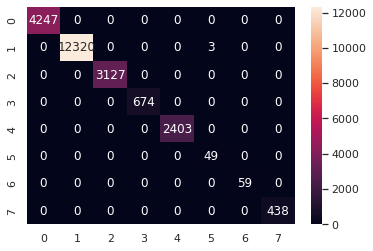

Solver: sag
=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.00

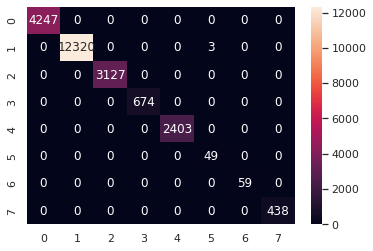

Solver: saga


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

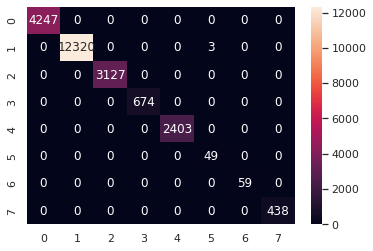

Solver: lbfgs
=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.

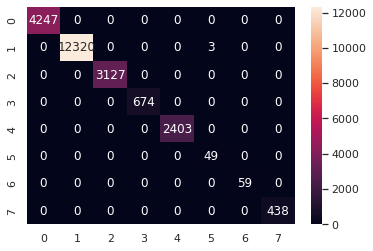

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# from the above link, some note-worthy points are below:
# * For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
# * For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
# So, only "newton-cg", "sag", "saga", "lbfgs" are used and max_iter is set to 1000 to overcome ConvergenceWarning

from sklearn.linear_model import LogisticRegression

for solver in ["newton-cg", "sag", "saga", "lbfgs"]:
    print(f"Solver: {solver}")
    classifier_logistic = LogisticRegression(random_state=RANDOM_STATE, solver=solver, max_iter=1000)
    classifier_logistic.fit(X_train, y_train)
    display_results(classifier_logistic)

## Naive Bayes

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

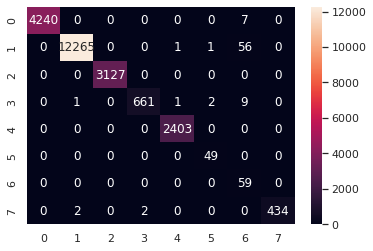

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      0.99      1.00       152
           4       1.00      1.00      1.00       156
           5       0.99      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.98      1.00      0.99        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

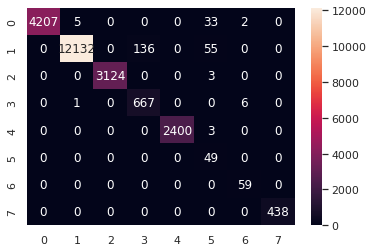

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

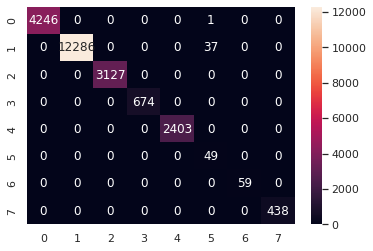

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       155
           1       0.86      0.99      0.92       147
           2       1.00      0.92      0.96       150
           3       0.98      0.95      0.96       152
           4       1.00      0.96      0.98       156
           5       0.69      0.84      0.76       146
           6       0.99      0.93      0.96       162
           7       1.00      0.95      0.97       148

    accuracy                           0.93      1216
   macro avg       0.94      0.93      0.93      1216
weighted avg       0.94      0.93      0.94      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.87      0.95      0.91        43
           2       1.00      0.97      0.99        40
           3       0.97      0.97  

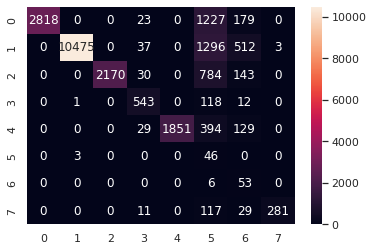

In [35]:
# https://scikit-learn.org/stable/modules/naive_bayes.html

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
# CategoricalNB is suitable only for classification with discrete features that are categorically distributed, which is not suitable for the data available and so is skipped.

for naive_bayes in [GaussianNB, MultinomialNB, ComplementNB, BernoulliNB]:
    classifier_nb = naive_bayes()
    classifier_nb.fit(X_train, y_train)
    display_results(classifier_nb)

## KNN Classifier

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       155
           1       0.86      0.88      0.87       147
           2       0.89      0.89      0.89       150
           3       0.85      0.93      0.89       152
           4       0.90      0.83      0.86       156
           5       0.87      0.93      0.90       146
           6       0.93      0.86      0.89       162
           7       0.92      0.86      0.89       148

    accuracy                           0.89      1216
   macro avg       0.89      0.89      0.89      1216
weighted avg       0.89      0.89      0.89      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        35
           1       0.62      0.77      0.69        43
           2       0.72      0.70      0.71        40
           3       0.69      0.66  

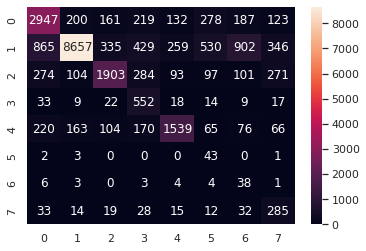

In [36]:
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier()
classifier_knn.fit(X_train, y_train)
display_results(classifier_knn)

## Decision Trees

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

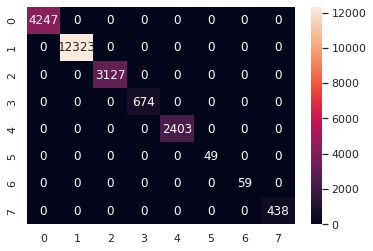

In [57]:
from sklearn.tree import DecisionTreeClassifier

classifier_tree = DecisionTreeClassifier(max_depth=32, random_state=RANDOM_STATE)
classifier_tree.fit(X_train, y_train)
display_results(classifier_tree)

## Random Forest

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.95      0.98        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00  

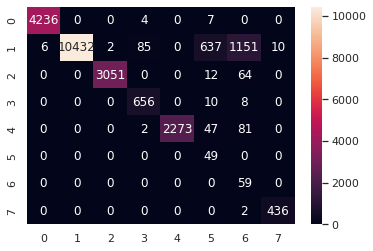

In [37]:
from sklearn.ensemble import RandomForestClassifier

classifier_forest = RandomForestClassifier(max_depth=32, random_state=RANDOM_STATE)
classifier_forest.fit(X_train, y_train)
display_results(classifier_forest)

## Adaboost Trees

=============== Train dataset ===============


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       155
           1       0.00      0.00      0.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       0.00      0.00      0.00       148

    accuracy                           0.76      1216
   macro avg       0.67      0.75      0.69      1216
weighted avg       0.67      0.76      0.70      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        35
           1       0.00      0.00      0.00        43
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        38
           4       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.25      1.00      0.40      4247
           1       0.00      0.00      0.00     12323
           2       1.00      1.00      1.00      3127
           3       1.00      1.00      1.00       674
           4       1.00      1.00      1.00      2403
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        59
           7       0.00      0.00      0.00       438

    accuracy                           0.45     23320
   macro avg       0.66      0.75      0.67     23320
weighted avg       0.32      0.45      0.34     23320



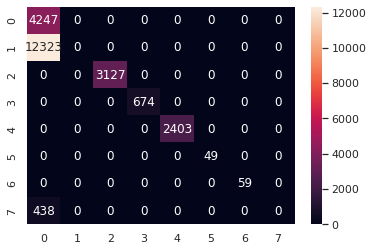

In [38]:
from sklearn.ensemble import AdaBoostClassifier

classifier_adaboost = AdaBoostClassifier(random_state=RANDOM_STATE)
classifier_adaboost.fit(X_train, y_train)
display_results(classifier_adaboost)

## SVM

=============== Train dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      0.99      1.00       156
           5       1.00      1.00      1.00       146
           6       0.99      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.95      0.98        43
           2       1.00      0.97      0.99        40
           3       0.95      0.97  

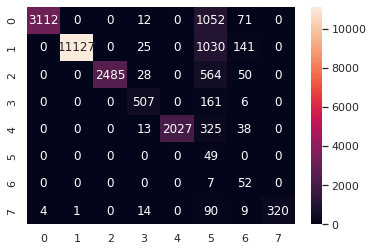

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

classifier_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
classifier_svm.fit(X_train, y_train)
display_results(classifier_svm)

## Reshape to be able to use in RNN Models

Ref: https://www.tensorflow.org/guide/keras/rnn

In [40]:
feature = 16
pad_dim = X_seen.shape[1] % feature
pad_dim = feature - pad_dim
pad_dim %= feature
timesteps = (X_seen.shape[1] + pad_dim) // feature

def timed_padded_X(X, pad_dim):
  pad = np.zeros((X.shape[0], pad_dim))
  padded_X = np.hstack((X, pad))
  padded_X = padded_X.reshape((X.shape[0], -1, feature))
  return padded_X.astype('float32')


# TODO reshaping logic
X_seen_timed = timed_padded_X(X_seen, pad_dim)
print(f"Timed padded: {X_seen_timed.shape}")
X_test_timed = timed_padded_X(X_test, pad_dim)
print(f"Timed padded: {X_test_timed.shape}")

Timed padded: (1520, 18, 16)
Timed padded: (23320, 18, 16)


In [41]:
X_train_timed, X_val_timed, y_train, y_val = train_test_split(X_seen_timed, y_seen, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Length of training data: {X_train_timed.shape[0]}")
print(f"Length of validation data: {X_val_timed.shape[0]}")

Length of training data: 1216
Length of validation data: 304


In [52]:
def display_rnn_results(model):
    for name, X, y_true in [
        ("Train", X_train_timed, y_train),
        ("Validation", X_val_timed, y_val),
        ("Test", X_test_timed, y_test)
    ]:
        print(f"=============== {name} dataset ===============")
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=-1)
        print(classification_report(y_true, y_pred))
    # y_pred = model.predict(X_test_timed)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.show()

## RNN

Epoch 1/25
38/38 [==============================] - 2s 18ms/step - loss: 2.3492 - accuracy: 0.1431 - val_loss: 2.2012 - val_accuracy: 0.1546
Epoch 2/25
38/38 [==============================] - 0s 10ms/step - loss: 2.0455 - accuracy: 0.2492 - val_loss: 2.1172 - val_accuracy: 0.1612
Epoch 3/25
38/38 [==============================] - 0s 10ms/step - loss: 1.8515 - accuracy: 0.3339 - val_loss: 1.9847 - val_accuracy: 0.2105
Epoch 4/25
38/38 [==============================] - 0s 10ms/step - loss: 1.5061 - accuracy: 0.4844 - val_loss: 1.7115 - val_accuracy: 0.3059
Epoch 5/25
38/38 [==============================] - 0s 10ms/step - loss: 1.0885 - accuracy: 0.7064 - val_loss: 1.0808 - val_accuracy: 0.6151
Epoch 6/25
38/38 [==============================] - 0s 10ms/step - loss: 0.7396 - accuracy: 0.8791 - val_loss: 0.7606 - val_accuracy: 0.7993
Epoch 7/25
38/38 [==============================] - 0s 10ms/step - loss: 0.5103 - accuracy: 0.9564 - val_loss: 0.5226 - val_accuracy: 0.8914
Epoch 8/25
38

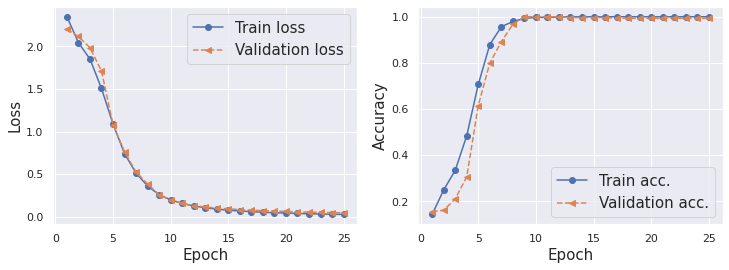

=============== Train dataset ===============
38/38 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       155
           1       1.00      1.00      1.00       147
           2       0.99      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      0.99      1.00       156
           5       1.00      1.00      1.00       146
           6       1.00      0.99      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00    

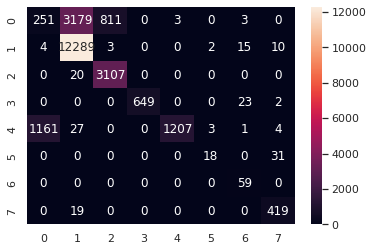

In [54]:
# Refering to https://www.tensorflow.org/guide/keras/rnn
def build_model_rnn():
    clear_session()
    reset_random_seeds()

    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.SimpleRNN(BATCH_SIZE, input_shape=(None, timesteps)))
    model.add(keras.layers.Dense(units=len(labels), name='output', activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model


model_rnn = build_model_rnn()
# model_rnn.build(input_shape=(None, 1, X_seen.shape[1]))  # todo fix shape
# model_rnn.summary()

history_rnn = model_rnn.fit(X_seen_timed, y_seen, epochs=EPOCHS, 
                            batch_size=BATCH_SIZE, validation_split=TEST_SIZE).history
model_rnn.summary()
plot_history(history_rnn)
display_rnn_results(model_rnn)

## LSTM

Epoch 1/25
38/38 [==============================] - 3s 30ms/step - loss: 2.1455 - accuracy: 0.1727 - val_loss: 2.1540 - val_accuracy: 0.1349
Epoch 2/25
38/38 [==============================] - 0s 5ms/step - loss: 1.8395 - accuracy: 0.3372 - val_loss: 2.1420 - val_accuracy: 0.0789
Epoch 3/25
38/38 [==============================] - 0s 4ms/step - loss: 1.2695 - accuracy: 0.5230 - val_loss: 2.0294 - val_accuracy: 0.1349
Epoch 4/25
38/38 [==============================] - 0s 5ms/step - loss: 0.7712 - accuracy: 0.7599 - val_loss: 1.5798 - val_accuracy: 0.3125
Epoch 5/25
38/38 [==============================] - 0s 5ms/step - loss: 0.4679 - accuracy: 0.9054 - val_loss: 1.2337 - val_accuracy: 0.7072
Epoch 6/25
38/38 [==============================] - 0s 5ms/step - loss: 0.2288 - accuracy: 0.9934 - val_loss: 0.5224 - val_accuracy: 0.8914
Epoch 7/25
38/38 [==============================] - 0s 5ms/step - loss: 0.1160 - accuracy: 0.9984 - val_loss: 0.3174 - val_accuracy: 0.9013
Epoch 8/25
38/38 [=

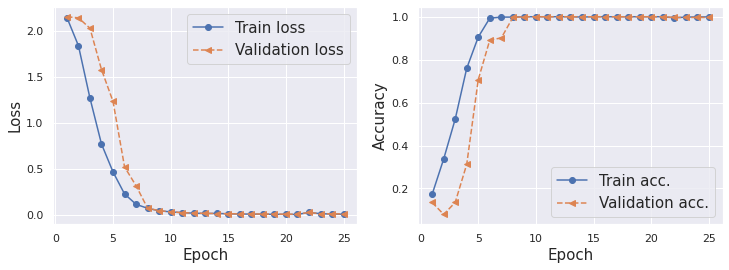

=============== Train dataset ===============
38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       155
           1       0.99      1.00      1.00       147
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       152
           4       1.00      0.99      1.00       156
           5       0.99      1.00      1.00       146
           6       1.00      1.00      1.00       162
           7       1.00      1.00      1.00       148

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216

=============== Validation dataset ===============
10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00    

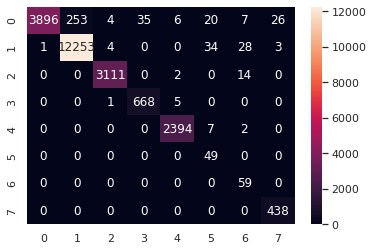

In [55]:
def build_model_lstm():
    clear_session()
    reset_random_seeds()

    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(BATCH_SIZE, input_shape=(None, timesteps)))
    model.add(keras.layers.Dense(units=len(labels), name='output', activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model


model_lstm = build_model_lstm()
# model_lstm.build(input_shape=(None, 1, X_seen.shape[1]))  # todo fix shape
# model_lstm.summary()

history_lstm = model_lstm.fit(X_seen_timed, y_seen, epochs=EPOCHS,
                              batch_size=BATCH_SIZE, validation_split=TEST_SIZE).history
model_lstm.summary()
plot_history(history_lstm)
display_rnn_results(model_lstm)

## GRUs

Epoch 1/25
38/38 [==============================] - 2s 21ms/step - loss: 2.1493 - accuracy: 0.1990 - val_loss: 2.1573 - val_accuracy: 0.1118
Epoch 2/25
38/38 [==============================] - 0s 4ms/step - loss: 1.9982 - accuracy: 0.2607 - val_loss: 2.1356 - val_accuracy: 0.1020
Epoch 3/25
38/38 [==============================] - 0s 5ms/step - loss: 1.9401 - accuracy: 0.2689 - val_loss: 2.1116 - val_accuracy: 0.1184
Epoch 4/25
38/38 [==============================] - 0s 4ms/step - loss: 1.9091 - accuracy: 0.2640 - val_loss: 2.0985 - val_accuracy: 0.1217
Epoch 5/25
38/38 [==============================] - 0s 5ms/step - loss: 1.8909 - accuracy: 0.2812 - val_loss: 2.0731 - val_accuracy: 0.1382
Epoch 6/25
38/38 [==============================] - 0s 5ms/step - loss: 1.8824 - accuracy: 0.2771 - val_loss: 2.0635 - val_accuracy: 0.1382
Epoch 7/25
38/38 [==============================] - 0s 4ms/step - loss: 1.8777 - accuracy: 0.2730 - val_loss: 2.0486 - val_accuracy: 0.1382
Epoch 8/25
38/38 [=

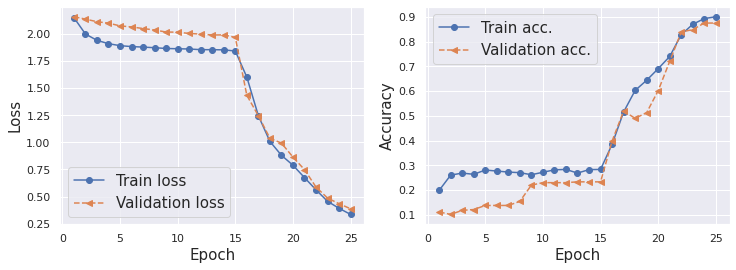

=============== Train dataset ===============
38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       155
           1       0.81      0.77      0.79       147
           2       1.00      0.99      0.99       150
           3       0.90      0.75      0.82       152
           4       0.99      1.00      0.99       156
           5       0.78      0.89      0.83       146
           6       0.98      1.00      0.99       162
           7       1.00      0.99      0.99       148

    accuracy                           0.90      1216
   macro avg       0.91      0.90      0.90      1216
weighted avg       0.91      0.90      0.90      1216

=============== Validation dataset ===============
10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        35
           1       0.83      0.81    

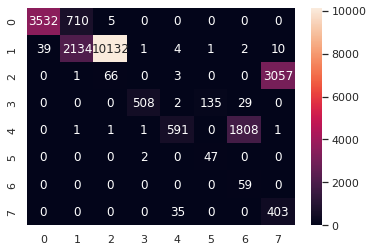

In [56]:
# Refering to https://www.tensorflow.org/guide/keras/rnn
def build_model_gru():
    clear_session()
    reset_random_seeds()

    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.GRU(BATCH_SIZE, input_shape=(None, timesteps)))
    model.add(keras.layers.Dense(units=len(labels), name='output', activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model


model_gru = build_model_gru()
# model_gru.build(input_shape=(None, 1, X_seen.shape[1]))  # todo fix shape
# model_gru.summary()

history_gru = model_gru.fit(X_seen_timed, y_seen, epochs=EPOCHS,
                              batch_size=BATCH_SIZE, validation_split=TEST_SIZE).history
model_gru.summary()
plot_history(history_gru)
display_rnn_results(model_gru)